# Data Story

### Results captured from Stathead Football
### https://stathead.com/football/
### https://stathead.com/football/nfl-combine-results.cgi


### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joypy
import missingno as msno

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

## Feature Engineering / Cleanup

## Build Height in Inches, Build Skill (Condensed Positions)

In [2]:

# Splits Height and converts to inches
def calc_height_in(val):
    raw = val.split('/')
    h_ft = int(raw[0])
    h_in = int(raw[1])
    return float((h_ft * 12) + h_in)

# Get Team Function
def get_Team(draft_str):
    return draft_str.split('/')[0].strip()

# Get Round Function
def get_Round(draft_str):
    return draft_str.split('/')[1].strip()

# Get Round Function
def get_PickNum(draft_str):
    return draft_str.split('/')[2].strip()

# Get Round Function
def get_YearDraft(draft_str):
    return draft_str.split('/')[3].strip()

# Build Offense or Defense
def OffenseDefense(pos_str):
    oPos = ['QB','OG','T','C','TE','OL','WR','RB','FB','P','K','LS']
    if pos_str in oPos:
        return 'O'
    else:
        return 'D'

# Write Common Skill position string
def skill(pos_str):
    oback = ['RB','FB','HB','TB']
    rcvr = ['TE','WR']
    spec = ['K','P','LS']
    oline = ['OG','T','C','OT','OL']
    dline = ['DL','DE','EDGE','DT','NT']
    db = ['DB','FS','SS','S','NICK','CB']
    lb = ['EDGE','ILB','OLB','LB']
        
    if pos_str in rcvr:
        return 'Receiver'
    elif pos_str in spec:
        return 'Specialist'
    elif pos_str in oline:
        return 'OLine'
    elif pos_str in dline:
        return 'DLine'
    elif pos_str in db:
        return 'DBack'
    elif pos_str in lb:
        return 'Linebacker'
    elif pos_str in oback:
        return 'OBack'
    elif pos_str == 'QB':
        return 'QB'
    else:
        return 'NA'
        
# Make target dataframe
df_raw = pd.DataFrame()

# Iterate over know study years
for year in range(2001,2022):
    df = pd.read_csv('.//data//sportsref_download_' + str(year) + '.xls.csv',
                                  dtype={'Height':str,
                                         'Drafted (tm/rnd/yr)':str},
                         parse_dates=False)

    # Dropped unnamed COlumn
    df.drop(columns='Unnamed: 7',inplace=True,axis=1)
    
    # Make First and Last Name Columns
    df[['FirstName', 'LastName']] = df['Player'].str.split(' ', 1, expand=True)
    
    # Map to the 
    df['Height-in'] = df['Height'].map(calc_height_in)
    df.drop(columns=['Height'],axis=1,inplace=True)
    
    # Split Drafted
    df['Drafted (tm/rnd/yr)'].fillna('-/-/-/-',inplace=True) # Inserts dummy string so splitter works
    # Bet Team 
    df['DraftTeam'] = df['Drafted (tm/rnd/yr)'].map(get_Team)
    df['Round'] = df['Drafted (tm/rnd/yr)'].map(get_Round).str.extract('(\d+)') # Get Round
    df['Pick'] = df['Drafted (tm/rnd/yr)'].map(get_PickNum).str.extract('(\d+)') # Get Pick
    df['YearDraft'] = df['Drafted (tm/rnd/yr)'].map(get_YearDraft).str.extract('(\d+)') # Get Year
    df['OD'] = df['Pos'].map(OffenseDefense) # Get Year
    df['Skill'] = df['Pos'].map(skill) # Get Year
    
    
    # Adjust Team Names to avoid duplicates / Team Moves
    df['DraftTeam'] = df['DraftTeam'].str.replace('Washington Redskins','Washington Football Team')
    df['DraftTeam'] = df['DraftTeam'].str.replace('San Diego Chargers','SD/LA Chargers')
    df['DraftTeam'] = df['DraftTeam'].str.replace('Los Angeles Chargers','SD/LA Chargers')
    df['DraftTeam'] = df['DraftTeam'].str.replace('Oakland Raiders','LV/Oak Raiders')
    df['DraftTeam'] = df['DraftTeam'].str.replace('Las Vegas Raiders','LV/Oak Raiders')
    df['DraftTeam'] = df['DraftTeam'].str.replace('St. Louis Rams','LA/STL Rams')
    df['DraftTeam'] = df['DraftTeam'].str.replace('Los Angeles Rams','LA/STL Rams')
    df['DraftTeam'] = df['DraftTeam'].str.replace('Las Vegas Raiders','LV/Oak Raiders')


    df.drop(columns='Drafted (tm/rnd/yr)',inplace=True)
    
    df_raw = pd.concat([df_raw,df],ignore_index=True)
    
    df_raw.to_csv('Cleaned_results.csv')


del df

C:\Users\Mike\AppData\Local\Temp/ipykernel_8596/2635354450.py:98: FutureWarning: The default value of regex will change from True to False in a future version.
  df['DraftTeam'] = df['DraftTeam'].str.replace('St. Louis Rams','LA/STL Rams')


### Create scaled performance Metrics

In [3]:
# Normalize Performance Columns
from sklearn.preprocessing import MinMaxScaler
# df_sample = df_raw[df_raw['Skill'] == 'Lineman'][['Player',
#                                                   'Pos',
#                                                   'Age',
#                                                   'School',
#                                                   'Wt',
#                                                   'Height-in',
#                                                   '40YD',
#                                                   'Vertical',
#                                                   'BenchReps',
#                                                   'Broad Jump',
#                                                   '3Cone',
#                                                   'Shuttle']]

pos = ['Receiver','Specialist','Lineman','Defensive Back','Linebacker','QB','NA']

# Scale these features


skills = ['OLine', 'DLine', 'Linebacker', 'Receiver', 'DBack', 'OBack', 'QB','Specialist']

df = pd.DataFrame()

# Scale by Skill (not to compare positions)
for skill in skills:
    scaler = MinMaxScaler()
    df_sample = df_raw[df_raw['Skill'] == skill]
    df_sample['Wt_s'] = scaler.fit_transform(df_sample[['Wt']])
    df_sample['Height-in_s'] = scaler.fit_transform(df_sample[['Height-in']])
    df_sample['40YD_s'] = scaler.fit_transform(df_sample[['40YD']])
    df_sample['Vertical_s'] = scaler.fit_transform(df_sample[['Vertical']])
    df_sample['BenchReps_s'] = scaler.fit_transform(df_sample[['BenchReps']])
    df_sample['Broad Jump_s'] = scaler.fit_transform(df_sample[['Broad Jump']])
    df_sample['3Cone_s'] = scaler.fit_transform(df_sample[['3Cone']])
    df_sample['Shuttle_s'] = scaler.fit_transform(df_sample[['Shuttle']])
    df = df.append(df_sample,ignore_index=True)


### What matters for OLine
### Height-in, Wt, BenchReps, 40YD, Shuttle

### What matters for DLine
### Height-in, Wt, BenchReps, 40YD, Shuttle

### What matters for OBack
### 40YD, Shuttle, Broad Jump, Vertical, 3Cone, Shuttle

### What matters for DBack
### 40YD, Vertical, 3Cone, Shuttle, Height-in

### What matters for Linebacker
### 40YD, BenchReps, 3Cone, Shuttle, Vertical

### What matters for Receiver
### 40YD, Vertical, 3Cone, Shuttle, Height-in

    if skill == 'OLine':
        df['Score'] = df['Wt_s'] + df['Height-in_s'] + df['BenchReps_s']
    elif skill == 'DLine':
        df['Score'] = df['Wt_s'] + df['Height-in_s'] + df['BenchReps_s']
    elif skill == 'Linebacker':
        df['Score'] = df['40YD_s'] + df['Shuttle_s'] + df['BenchReps_s']
    elif skill == 'Receiver':
        df['Score'] = df['40YD_s'] + df['Vertical_s'] + df['3Cone_s']
    elif skill == 'DBack':
        df['Score'] = df['40YD_s'] + df['Vertical_s'] + df['3Cone_s']
    elif skill == 'OBack':
        df['Score'] = df['40YD_s'] + df['BenchReps_s'] + df['3Cone_s']
    else:
        pass




df['Age_s'] = scaler.fit_transform(df[['Age']])

df_raw = df



C:\Users\Mike\AppData\Local\Temp/ipykernel_8596/3859434246.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['Wt_s'] = scaler.fit_transform(df_sample[['Wt']])
C:\Users\Mike\AppData\Local\Temp/ipykernel_8596/3859434246.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['Height-in_s'] = scaler.fit_transform(df_sample[['Height-in']])
C:\Users\Mike\AppData\Local\Temp/ipykernel_8596/3859434246.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

## What features are missing?
40 YD is a key metric collected for players, this is the most prevalent stat

<AxesSubplot:>

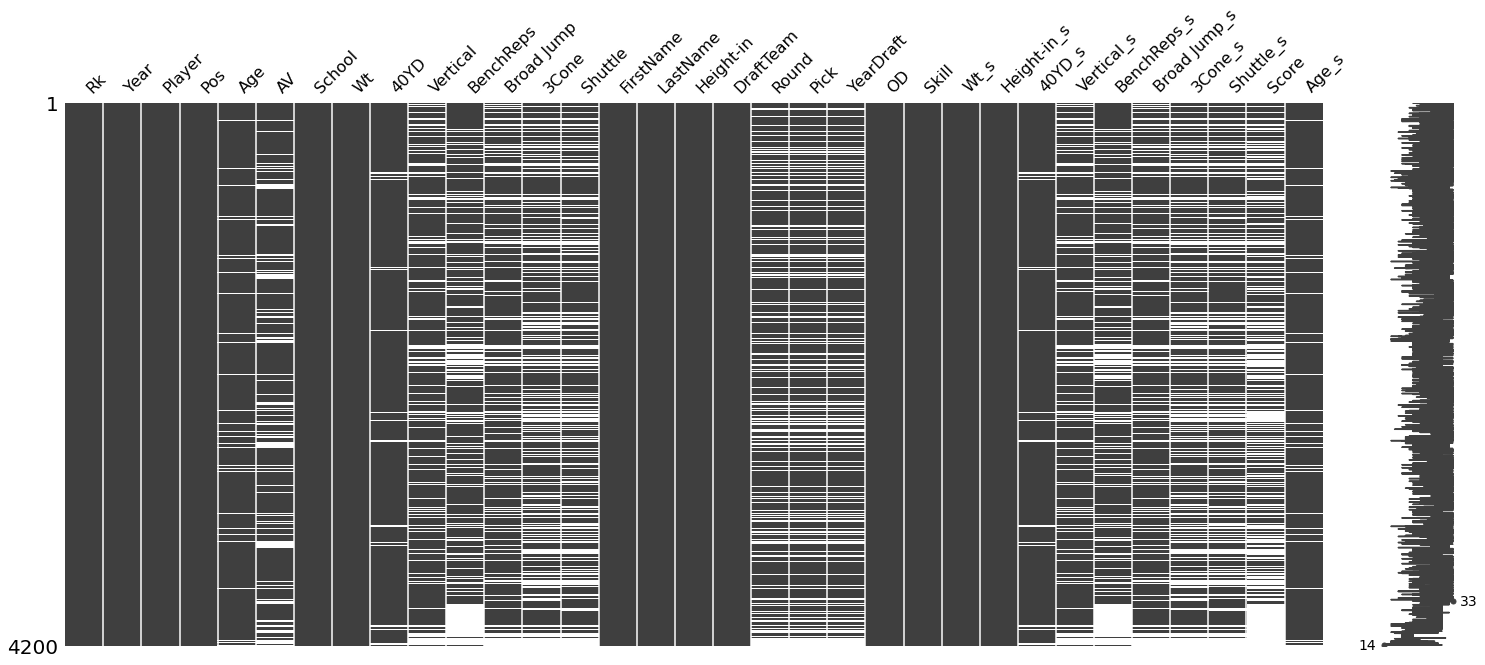

In [4]:
msno.matrix(df_raw)

# Visualizations and Aggregations

## See Quantities by Skill

In [5]:
df_draft = df_raw.groupby('Skill').size().sort_values(ascending=False)

In [6]:
# sns.barplot(data=df_draft,x='',y='')

In [7]:
pt = df_raw[['School','Skill','Pos']].pivot_table( \
                index=['School'],
                columns='Skill',
                values='Pos',
                       # margins='True',
                aggfunc=len,
                margins=True,
                sort='True').sort_values(by='All',ascending=False)

pt_filt = pt[(pt['All'] > 50) & (pt['All'] < 200)]
pt_filt.drop(labels=['All'],axis=1,inplace=True)

C:\Users\Mike\.conda\envs\Data\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## What are the top 25 schools in terms of total draft picks and what is the breakdown of player skill types?

In [8]:
fig = px.bar(pt_filt,title='Top Schools and Draft Choices, 2001-2021')
fig.show()

#### Miami and Ohio State have the largest amount of Receivers drafted in the last 20 years! (23 each or at least 1 per year)

## What is the breakdown of skill types drafted for each year?

In [9]:
# New DataFrame by Year
pt2 = df_raw[['Year','Skill','Pos']].pivot_table( \
                index=['Year'],
                columns='Skill',
                values='Pos',
                       # margins='True',
                aggfunc=len,
                margins=True,
                sort='True').sort_values(by='All',ascending=False)

pt_filt_2 = pt2[(pt2['All'] > 50) & (pt2['All'] < 201)]
pt_filt_2.drop(labels=['All'],axis=1,inplace=True)

C:\Users\Mike\.conda\envs\Data\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## What Skills were drafted per year?

In [10]:
# Barplot of years
years = [str(x) for x in range(2000,2022)]
fig = px.bar(pt_filt_2,
            labels=dict(x=years),
            title='Skills Drafted Per Year, 2001-2021')
fig.update_xaxes(nticks=20,dtick=1)
fig.show()

### 2020 was a big year for receivers, with 50 receivers drafted!

In [11]:
pt = df_raw[['DraftTeam','Skill','Pos']].pivot_table( \
                index=['DraftTeam'],
                columns='Skill',
                values='Pos',
                       # margins='True',
                aggfunc=len,
                margins=True,
                sort='True').sort_values(by='All',ascending=False)

pt_filt = pt[(pt['All'] > 50) & (pt['All'] < 200)]
pt_filt.drop(labels=['All'],axis=1,inplace=True)

# Strip plot of Skill Positions and 40 YD times over years

Text(0.5, 0, 'Year')

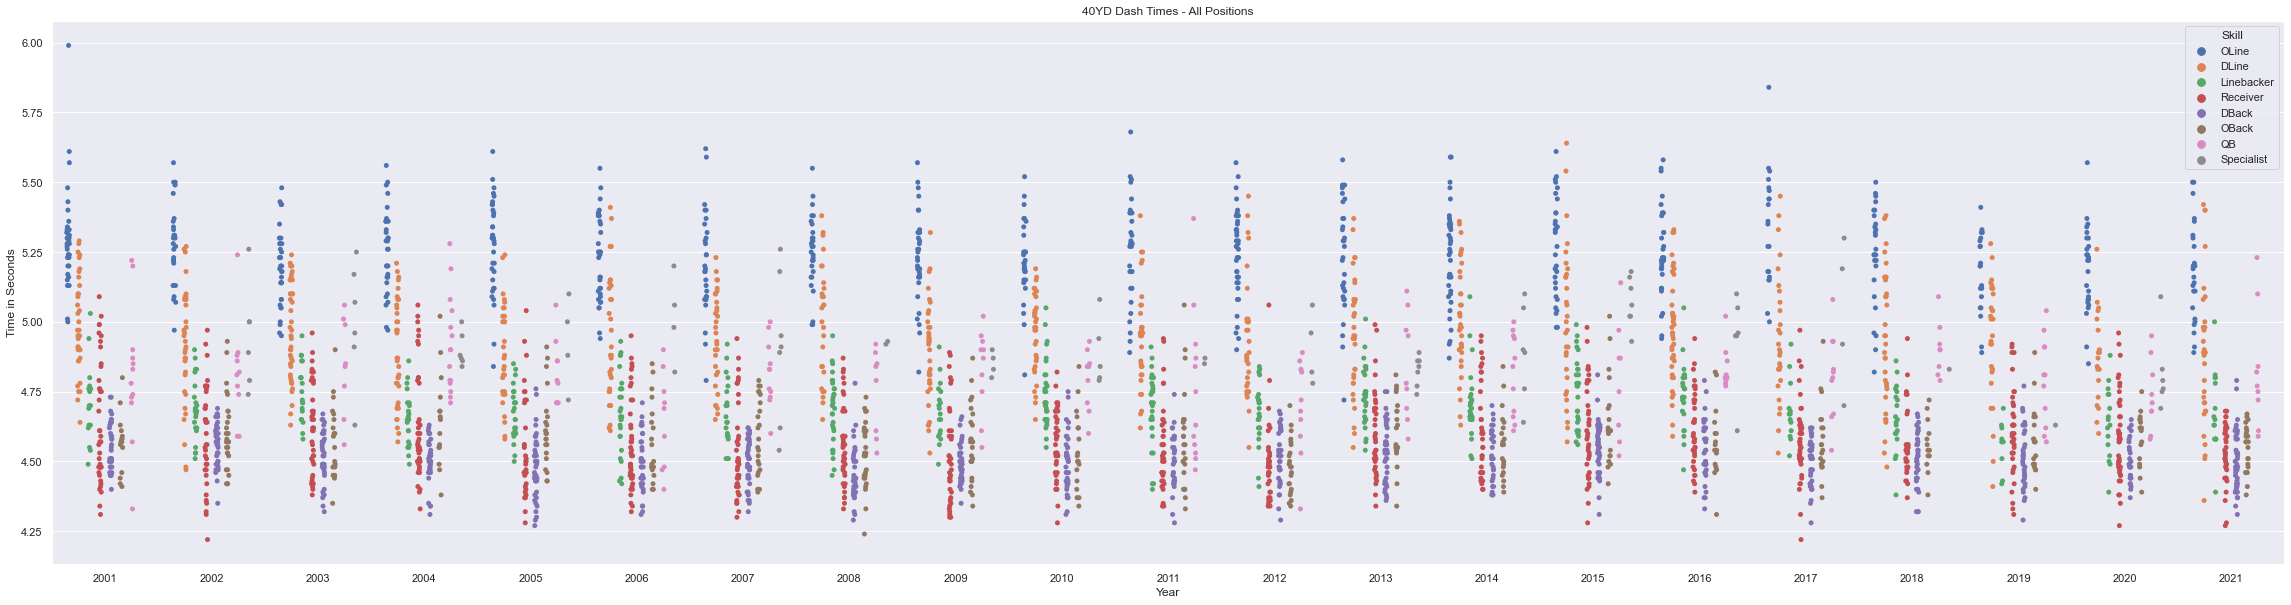

In [12]:
# Stripplot of 40YD Times
sns.set(rc={'figure.figsize':(40,10)})
ax = sns.stripplot(data=df_raw,x='Year',y='40YD',hue='Skill',dodge=True)
ax.set_title('40YD Dash Times - All Positions')
ax.set_ylabel('Time in Seconds')
ax.set_xlabel('Year')

Of the three players that ran below a 4.25 40 YD time, they were used on Offense, This makes sense as there's no defense for the fastest player

## Of the fastest skill groups (Receivers and DBacks), how do they compare?

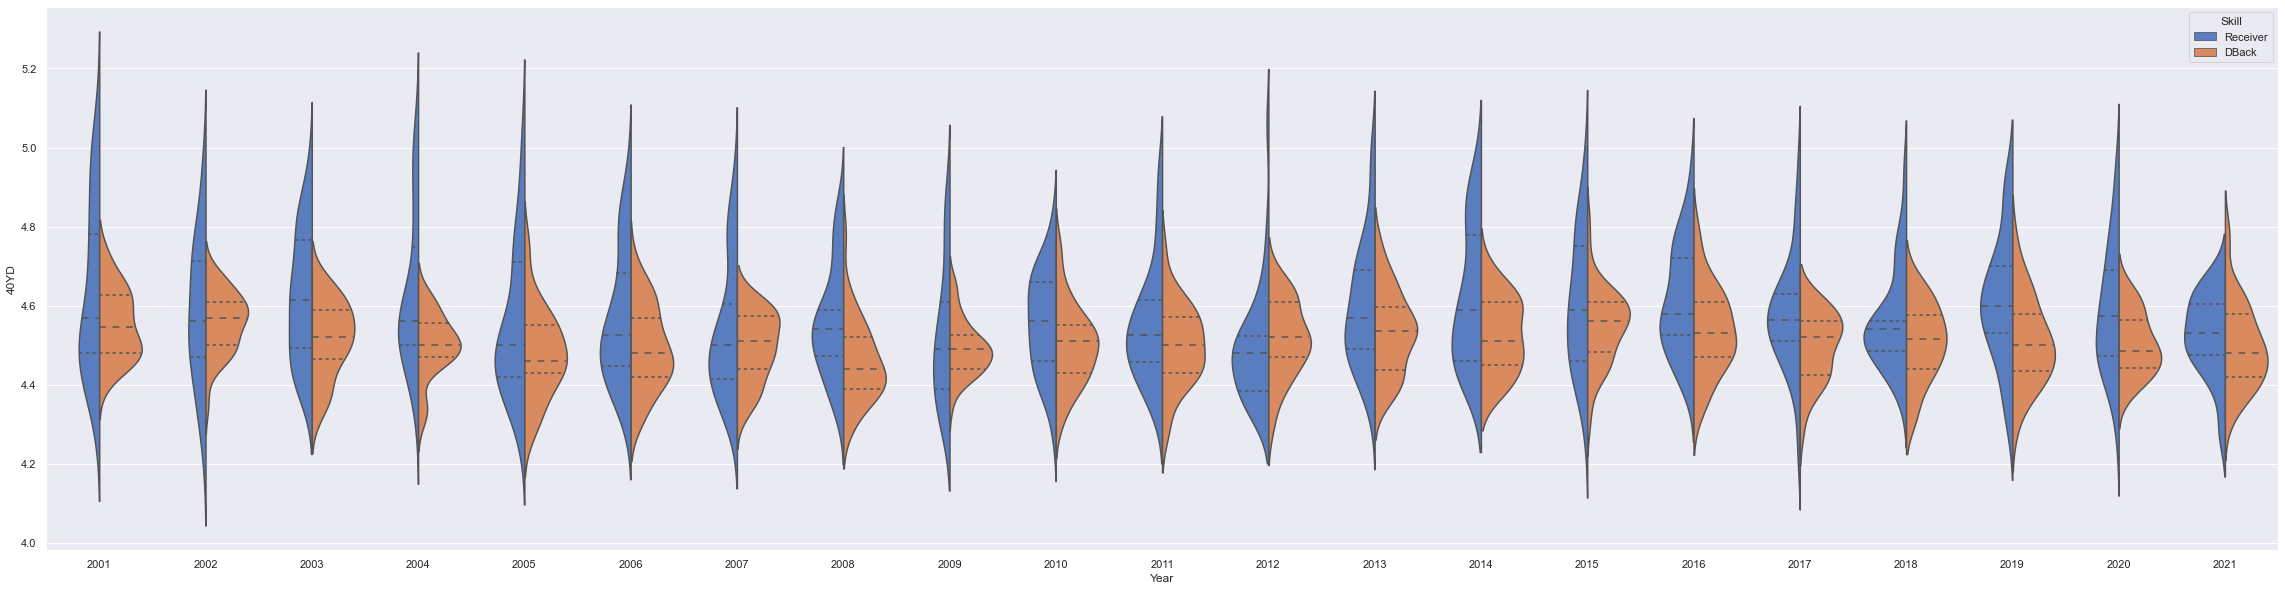

In [55]:
df_sample = df_raw[(df_raw['Skill'] == 'Receiver') | (df_raw['Skill'] == 'DBack')]
ax = sns.violinplot(x="Year", 
                    y="40YD", 
                    hue="Skill", 
                    data=df_sample, 
                    palette="muted", 
                    split=True,
                    inner='quartile')

### There is a wider variation of Receiver speeds
### The DBack position seems to be less spread, could it indicate there's more room for error in a traditionally difficult position to play?
### Other than some outliers, it seems the mean of the DBack speeds are

# Strip Plot of Player Weights over Years

Text(0.5, 0, 'Year')

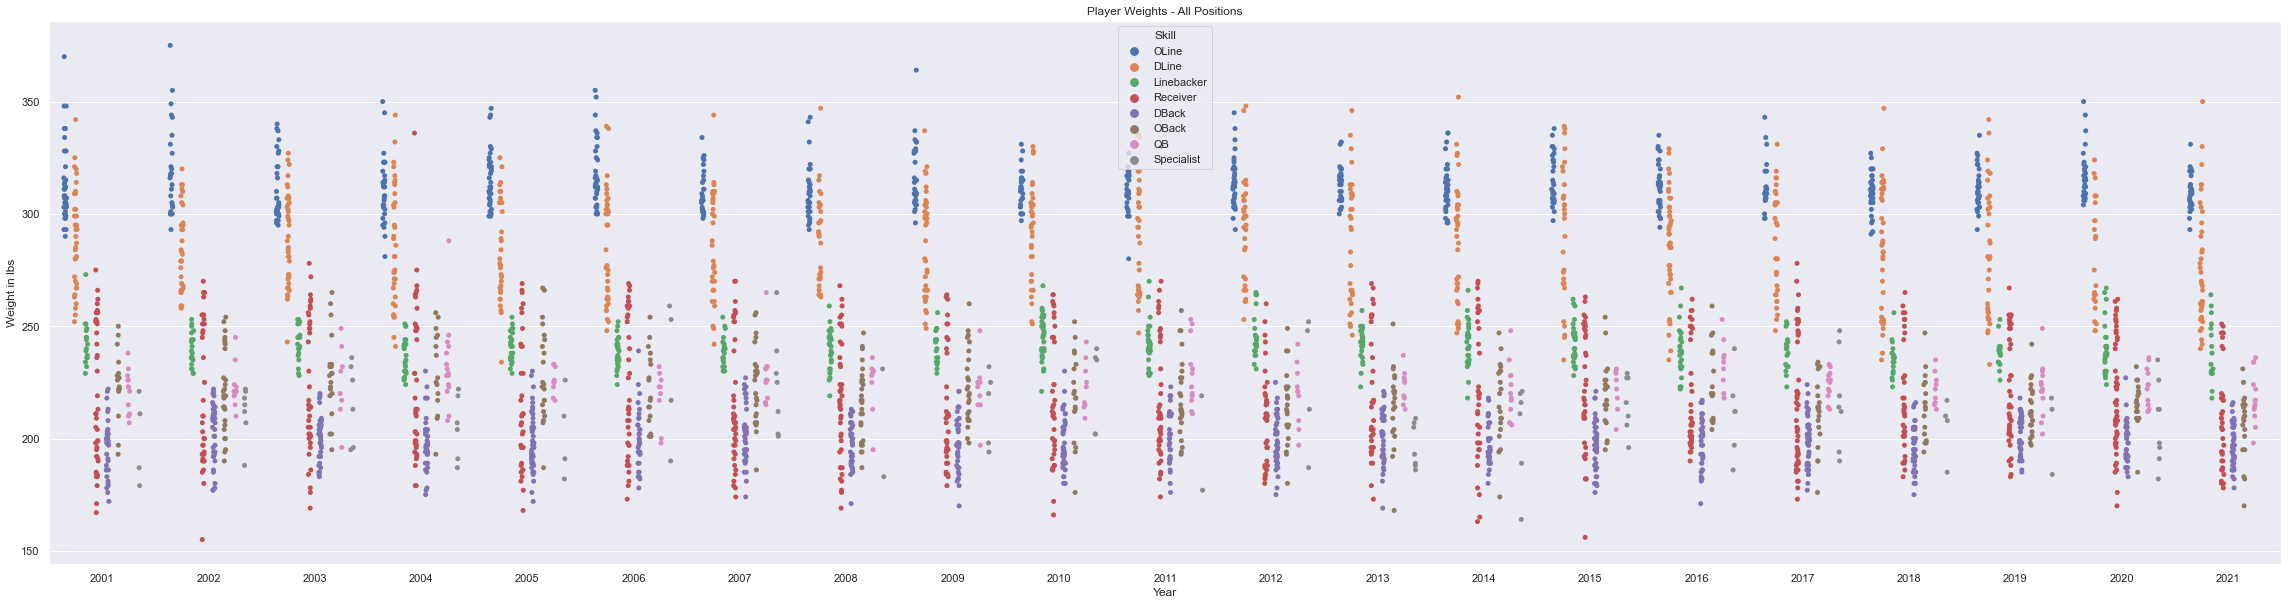

In [13]:
# Stripplot of Weights
sns.set(rc={'figure.figsize':(40,10)})
ax = sns.stripplot(data=df_raw,x='Year',y='Wt',hue='Skill',dodge=True)
ax.set_title('Player Weights - All Positions')
ax.set_ylabel('Weight in lbs')
ax.set_xlabel('Year')

In [15]:
df_sample.columns

Index(['Rk', 'Year', 'Player', 'Pos', 'Age', 'AV', 'School', 'Wt', '40YD',
       'Vertical', 'BenchReps', 'Broad Jump', '3Cone', 'Shuttle', 'FirstName',
       'LastName', 'Height-in', 'DraftTeam', 'Round', 'Pick', 'YearDraft',
       'OD', 'Skill', 'Wt_s', 'Height-in_s', '40YD_s', 'Vertical_s',
       'BenchReps_s', 'Broad Jump_s', '3Cone_s', 'Shuttle_s'],
      dtype='object')

## Relationships between numeric columns

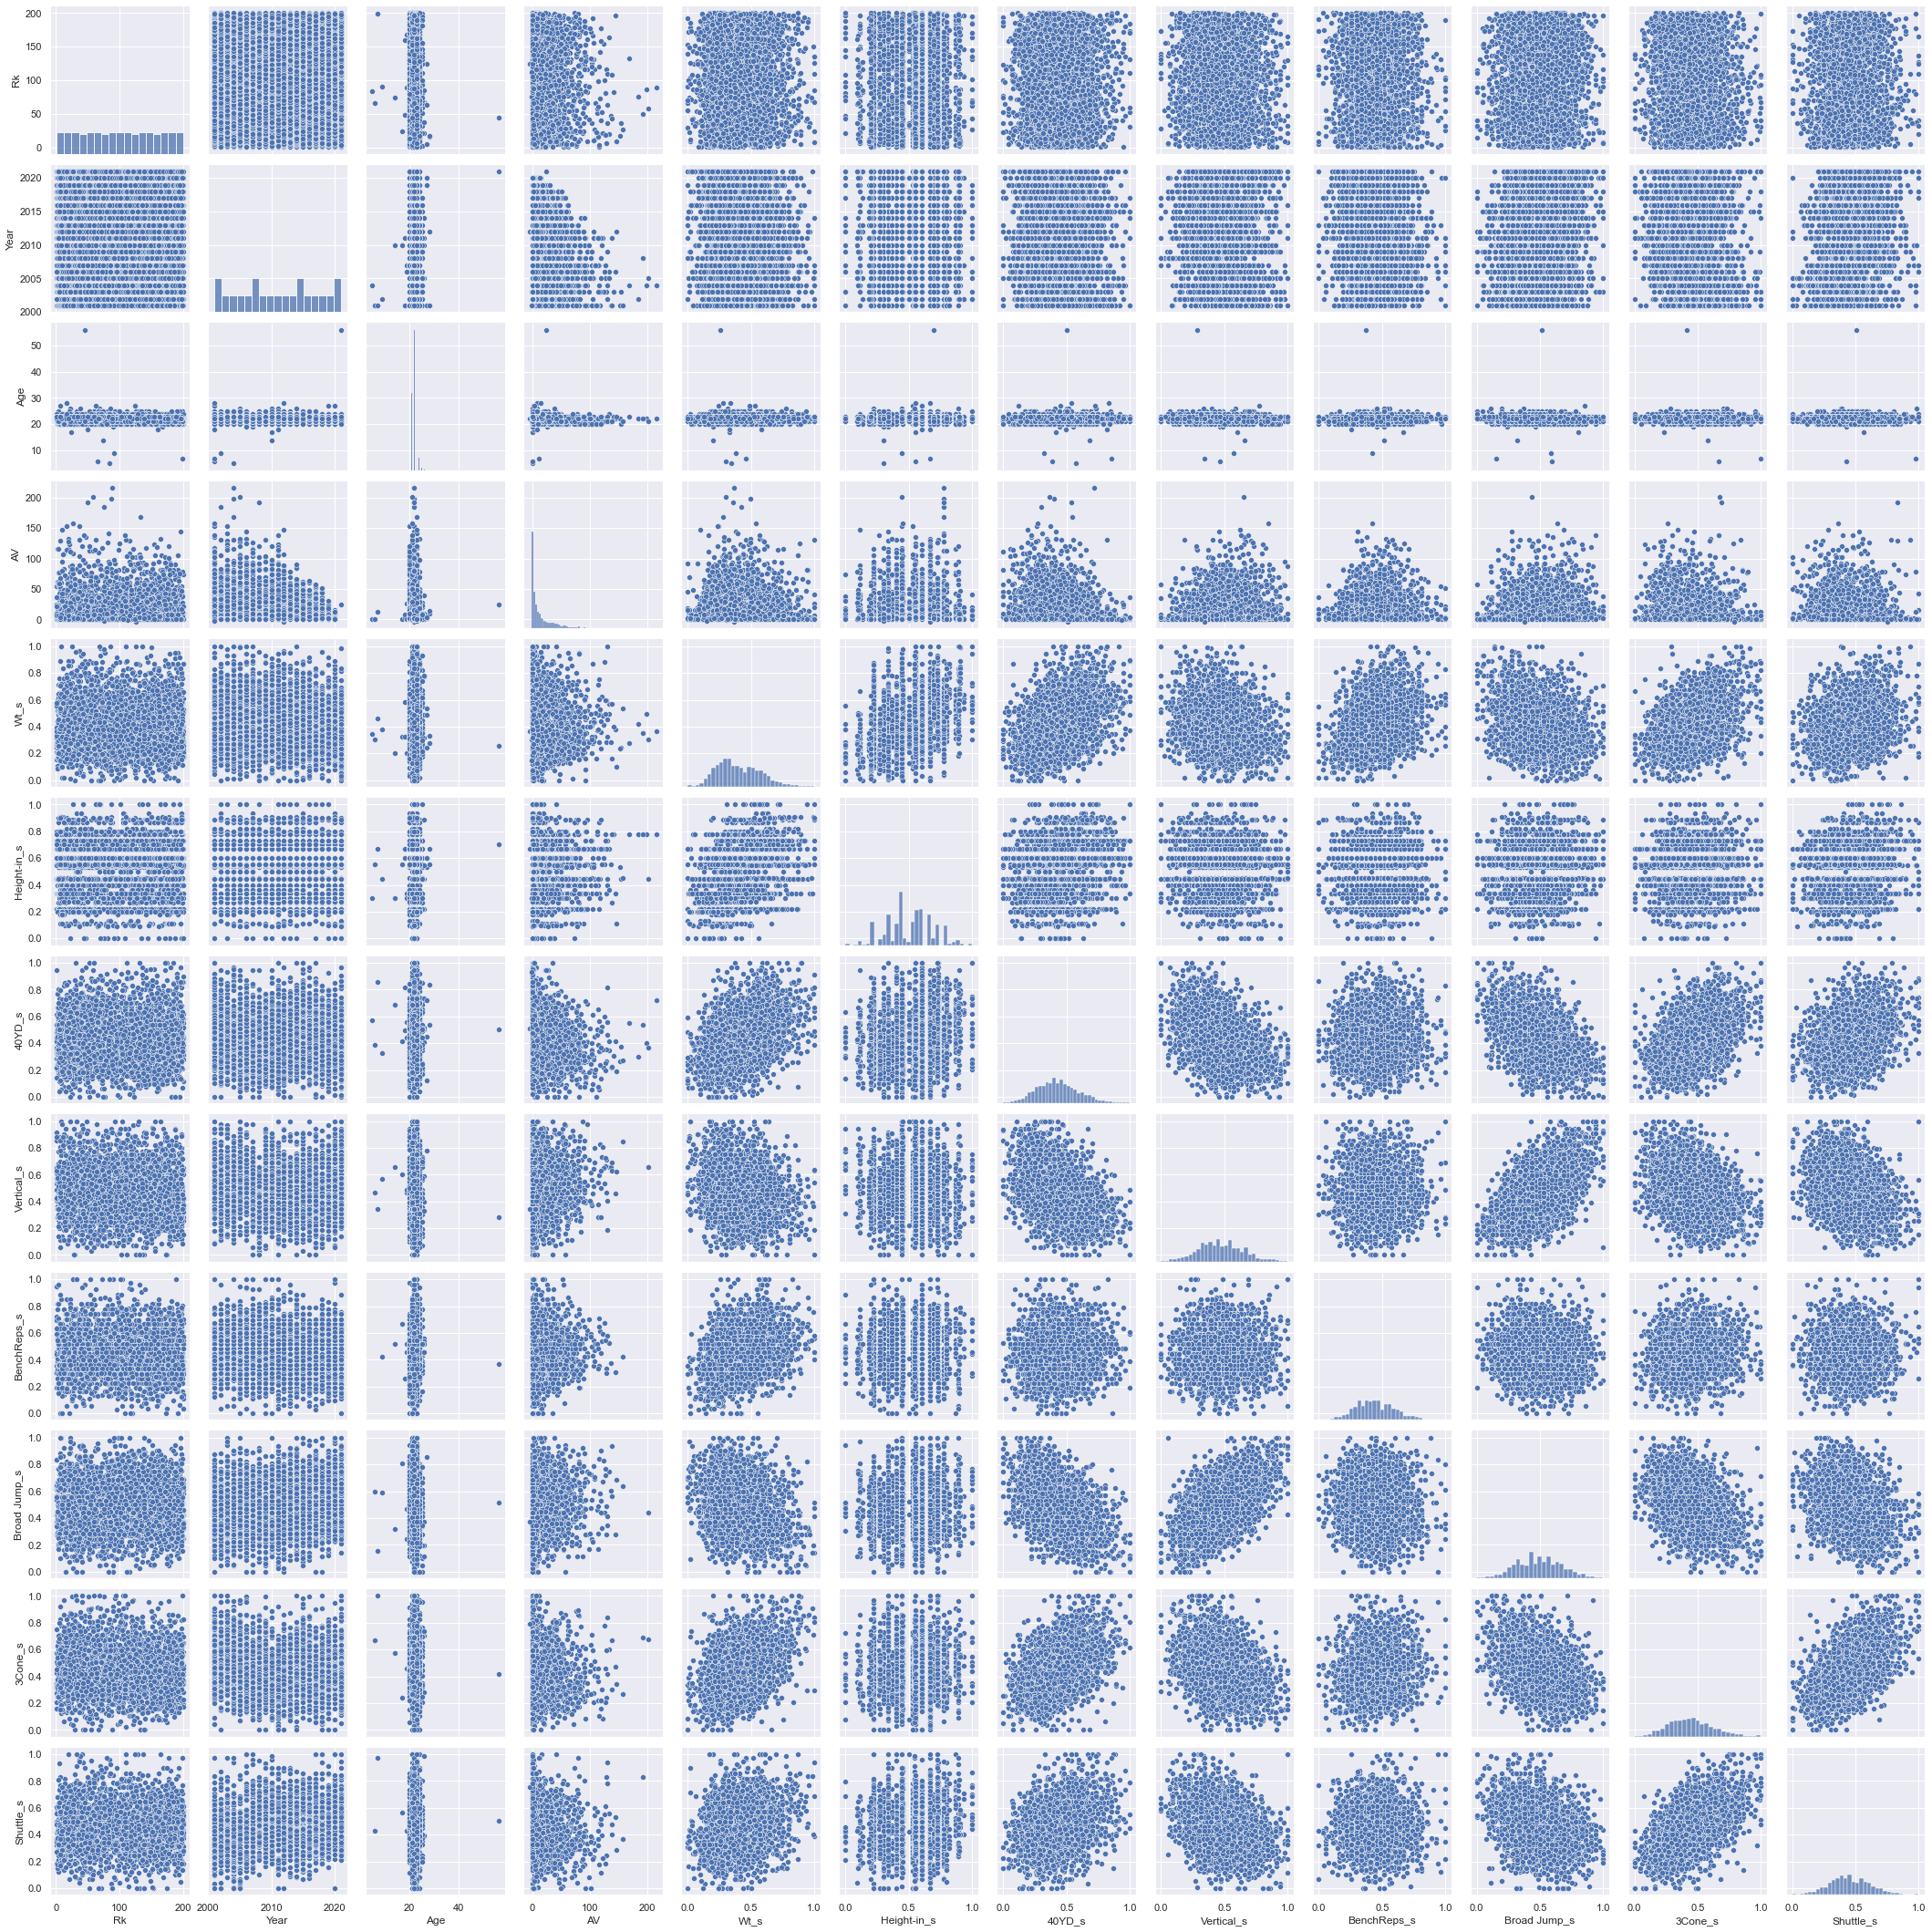

In [17]:
df_sample=df_raw[[
                    'Rk',
                    'Year',
                    'Age',
                    'AV',
                    'Wt_s',
                    'Height-in_s',
                    '40YD_s',
                    'Vertical_s',
                    'BenchReps_s',
                    'Broad Jump_s',
                    '3Cone_s',
                    'Shuttle_s'
                    
]]
sns.pairplot(df_sample)

Vertical and Broad Jump have positive correlation since they involve some leaping ability
Shuttle and 3 Cone are quickness, start stop drills and have positive correlation

## Fastest Players by 40 YD Time

In [20]:
df_sample = df_raw.sort_values(by='40YD')
df_sample.head(20)

Rk  Year                       Player Pos   Age    AV           School  \
2476   77  2017                    John Ross  WR  21.0   5.0       Washington   
1896   37  2002            Donte' Stallworth  WR  21.0  45.0        Tennessee   
3602  123  2008                Chris Johnson  RB  22.0  81.0    East Carolina   
2821   53  2005               Stanford Routt  CB  21.0  25.0          Houston   
2595   73  2020              Henry Ruggs III  WR  21.0   4.0          Alabama   
2649   75  2021             Anthony Schwartz  WR  20.0   NaN           Auburn   
2235  199  2010                  Jacoby Ford  WR  22.0  12.0          Clemson   
2658  117  2021                Rondale Moore  WR  20.0   NaN           Purdue   
3266  116  2017                 Jalen Myrick  CB  22.0   0.0        Minnesota   
3040   25  2011            Demarcus Van Dyke  CB  22.0   3.0       Miami (FL)   
2400  100  2015                  J.J. Nelson  WR  22.0  12.0   Ala-Birmingham   
2029  113  2005                Jerome Mathis  WR  21.0   4.0     Kansas State   
2816   15  2005            Fabian Washington  CB  21.0  22.0         Nebraska   
2940   54  2008  Dominique Rodgers-Cromartie  CB  21.0  64.0  Tennessee State   
3333    5  2019                Zedrick Woods   S   NaN   NaN      Mississippi   
3076   58  2012                Josh Robinson  CB  21.0  11.0  Central Florida   
2194  169  2009          Darrius Heyward-Bey  WR  22.0  26.0         Maryland   
2167   30  2009                  Mike Thomas  WR  21.0  22.0          Arizona   
2813    8  2005             Darrent Williams  CB  22.0  11.0   Oklahoma State   
2115  171  2007                 Yamon Figurs  WR  24.0   2.0     Kansas State   

       Wt  40YD  Vertical  ...      Wt_s  Height-in_s    40YD_s  Vertical_s  \
2476  188  4.22      37.0  ...  0.182320     0.400000  0.000000    0.558140   
1896  197  4.22       NaN  ...  0.232044     0.533333  0.000000         NaN   
3602  197  4.24      35.0  ...  0.292929     0.545455  0.000000    0.515152   
2821  193  4.27      36.5  ...  0.342857     0.600000  0.000000    0.457143   
2595  188  4.27      42.0  ...  0.182320     0.400000  0.057471    0.790698   
2649  186  4.27      32.0  ...  0.171271     0.533333  0.057471    0.325581   
2235  186  4.28      33.5  ...  0.171271     0.266667  0.068966    0.395349   
2658  180  4.28      42.5  ...  0.138122     0.133333  0.068966    0.813953   
3266  200  4.28      37.5  ...  0.442857     0.300000  0.018519    0.514286   
3040  176  4.28      33.5  ...  0.100000     0.600000  0.018519    0.285714   
2400  156  4.28      36.0  ...  0.005525     0.333333  0.068966    0.511628   
2029  181  4.28      35.5  ...  0.143646     0.400000  0.068966    0.488372   
2816  188  4.29      41.5  ...  0.271429     0.300000  0.037037    0.742857   
2940  184  4.29      38.5  ...  0.214286     0.600000  0.037037    0.571429   
3333  205  4.29      34.5  ...  0.514286     0.400000  0.037037    0.342857   
3076  199  4.29      38.5  ...  0.428571     0.300000  0.037037    0.571429   
2194  210  4.30      38.5  ...  0.303867     0.600000  0.091954    0.627907   
2167  195  4.30      40.5  ...  0.220994     0.200000  0.091954    0.720930   
2813  176  4.30      39.0  ...  0.100000     0.200000  0.055556    0.600000   
2115  174  4.30       NaN  ...  0.104972     0.400000  0.091954         NaN   

     BenchReps_s Broad Jump_s   3Cone_s Shuttle_s     Score     Age_s  
2476         NaN     0.853659       NaN       NaN       NaN  0.313725  
1896         NaN          NaN       NaN       NaN       NaN  0.313725  
3602         NaN     0.805556       NaN       NaN       NaN  0.333333  
2821         NaN     0.560976  0.255474  0.148515       NaN  0.313725  
2595         NaN     0.804878       NaN       NaN       NaN  0.313725  
2649         NaN     0.609756  0.464052  0.477064       NaN  0.294118  
2235    0.387097     0.414634  0.379085  0.651376  0.835147  0.333333  
2658         NaN          NaN  0.150327  0.302752       NaN  0.294118

## Best Vertical Jump

In [23]:
df_sample = df_raw.sort_values(by='Vertical', ascending=False)
df_sample.head(20)

Rk  Year                 Player  Pos   Age    AV            School  \
2665  165  2021      Josh Imatorbhebhe   WR  22.0   NaN          Illinois   
2820   48  2005      Gerald Sensabaugh    S  21.0  35.0    North Carolina   
1456   22  2005           Cameron Wake  OLB  23.0  88.0        Penn State   
2831  109  2005         Chris McKenzie   CB  22.0   0.0     Arizona State   
2963   15  2009      Donald Washington   CB  22.0   4.0        Ohio State   
2603   99  2020  Donovan Peoples-Jones   WR  21.0   2.0          Michigan   
3201  138  2015            Byron Jones   CB  22.0  38.0       Connecticut   
3268  124  2017          Obi Melifonwu    S  22.0   1.0       Connecticut   
3029  159  2010         A.J. Jefferson   CB  21.0   8.0      Fresno State   
3341   37  2019         Juan Thornhill    S  23.0   9.0          Virginia   
3399    6  2021           Marco Wilson   CB  22.0   NaN           Florida   
1880  127  2001           Kevin Kasper   WR  23.0   2.0              Iowa   
2846  175  2005             Dustin Fox    S  22.0   0.0        Ohio State   
2293   96  2012           Kashif Moore   WR  23.0   0.0       Connecticut   
3252   11  2017        Marcus Williams    S  20.0  20.0              Utah   
2487  112  2017            Speedy Noil   WR   NaN   NaN         Texas A&M   
2818   36  2005           Scott Starks   CB  21.0   4.0         Wisconsin   
1882  139  2001           Cedric James   WR  21.0   0.0               TCU   
3418   81  2021         Robert Rochell   DB  22.0   NaN  Central Arkansas   
3712  130  2013      Christine Michael   RB  22.0   9.0         Texas A&M   

       Wt  40YD  Vertical  ...      Wt_s  Height-in_s    40YD_s  Vertical_s  \
2665  218  4.53      46.5  ...  0.348066     0.533333  0.356322    1.000000   
2820  214  4.44      46.0  ...  0.642857     0.600000  0.314815    1.000000   
1456  236  4.65      45.5  ...  0.327273     0.666667  0.380282    1.000000   
2831  185  4.32      45.0  ...  0.228571     0.100000  0.092593    0.942857   
2963  197  4.50      45.0  ...  0.400000     0.600000  0.425926    0.942857   
2603  212  4.48      44.5  ...  0.314917     0.600000  0.298851    0.906977   
3201  199  4.43      44.5  ...  0.428571     0.600000  0.296296    0.914286   
3268  224  4.40      44.0  ...  0.785714     0.900000  0.240741    0.885714   
3029  193  4.42      44.0  ...  0.342857     0.600000  0.277778    0.885714   
3341  205  4.42      44.0  ...  0.514286     0.600000  0.277778    0.885714   
3399  191  4.37      43.5  ...  0.314286     0.400000  0.185185    0.857143   
1880  199  4.42      43.5  ...  0.243094     0.533333  0.229885    0.860465   
2846  191  4.43      43.5  ...  0.314286     0.400000  0.296296    0.857143   
2293  180  4.36      43.5  ...  0.138122     0.266667  0.160920    0.860465   
3252  202  4.56      43.5  ...  0.471429     0.600000  0.537037    0.857143   
2487  199   NaN      43.5  ...  0.243094     0.400000       NaN    0.860465   
2818  172  4.37      43.0  ...  0.042857     0.100000  0.185185    0.828571   
1882  204  4.49      43.0  ...  0.270718     0.600000  0.310345    0.837209   
3418  193  4.41      43.0  ...  0.342857     0.400000  0.259259    0.828571   
3712  220  4.54      43.0  ...  0.525253     0.454545  0.365854    1.000000   

     BenchReps_s Broad Jump_s   3Cone_s Shuttle_s     Score     Age_s  
2665    0.677419     0.878049  0.444444  0.596330  1.478186  0.333333  
2820    0.555556     0.658537       NaN       NaN       NaN  0.313725  
1456    0.322581     0.921569  0.427481  0.220183  1.130343  0.352941  
2831    0.148148     0.731707  0.452555  0.564356  0.693295  0.333333  
2963    0.259259     0.707317  0.408759  0.445545  1.093944  0.333333  
2603         NaN     1.000000       NaN       NaN       NaN  0.313725  
3201         NaN     1.000000  0.364964  0.188119       NaN  0.333333  
3268    0.555556     0.853659       NaN       NaN       NaN  0.333333  
3029    0.185185     0.487805  0.321168  0.247525  0.784131  0.313725  
3341    0

## Strongest Ranked Players by Skill
Sorted on scaled values, normalized to each skill group

In [47]:
df_sample = df_raw.sort_values(by='BenchReps_s', ascending=False)
df_sample.head(20)[['Player', 'Year','Skill','Pos','BenchReps','40YD']]

Player  Year       Skill  Pos  BenchReps  40YD
3945       Brady Quinn  2007          QB   QB       24.0  4.73
1021      Stephen Paea  2011       DLine   DT       49.0  4.98
302       Mitch Petrus  2010       OLine   OG       45.0  5.34
1484       Terna Nande  2006  Linebacker  OLB       41.0  4.51
3447      Moran Norris  2001       OBack   FB       37.0  4.63
2118      Daniel Coats  2007    Receiver   TE       34.0  4.94
4193      Michael Turk  2020  Specialist    P       25.0  4.79
1976   Benjamin Watson  2004    Receiver   TE       34.0  4.50
2973   Jamarca Sanford  2009       DBack    S       29.0  4.43
626        Netane Muti  2020       OLine   OL       44.0   NaN
2705          Coy Wire  2002       DBack    S       28.0  4.56
2734        Chris Hope  2002       DBack    S       28.0  4.58
3116   Shamarko Thomas  2013       DBack    S       28.0  4.42
129        Scott Young  2005       OLine   OG       43.0  5.08
3546      Naufahu Tahi  2006       OBack   FB       35.0  4.85
2066     Tim Massaquoi  2006    Receiver   TE       32.0  4.85
2950    Tyrell Johnson  2008       DBack    S       27.0  4.41
2916     Chris Houston  2007       DBack   CB       27.0  4.32
3047  Da'Norris Searcy  2011       DBack    S       27.0  4.55
2338    Vance McDonald  2013    Receiver   TE       31.0  4.69

## Fastest Players by Skill
These are the fastest players by the lowest 40 YD time by skill group

In [36]:
df_sample = df_raw.sort_values(by='40YD_s', ascending=True)
df_sample.head(20)[['Player', 'Year','Skill','Pos','40YD']]

Player  Year       Skill   Pos  40YD
3999               Robert Griffin  2012          QB    QB  4.33
413                  Lane Johnson  2013       OLine    OT  4.72
2476                    John Ross  2017    Receiver    WR  4.22
4129                 Adam Podlesh  2007  Specialist     P  4.54
1793              Shaquem Griffin  2018  Linebacker   OLB  4.38
3602                Chris Johnson  2008       OBack    RB  4.24
1348                  Jayson Oweh  2021       DLine    DE  4.36
1896            Donte' Stallworth  2002    Receiver    WR  4.22
2821               Stanford Routt  2005       DBack    CB  4.27
3878                 Michael Vick  2001          QB    QB  4.33
1819               Isaiah Simmons  2020  Linebacker    LB  4.39
1843                Micah Parsons  2021  Linebacker    LB  4.39
3266                 Jalen Myrick  2017       DBack    CB  4.28
3040            Demarcus Van Dyke  2011       DBack    CB  4.28
1614                  Dontay Moch  2011  Linebacker   OLB  4.40
2940  Dominique Rodgers-Cromartie  2008       DBack    CB  4.29
3076                Josh Robinson  2012       DBack    CB  4.29
2816            Fabian Washington  2005       DBack    CB  4.29
3333                Zedrick Woods  2019       DBack     S  4.29
1282                 Montez Sweat  2019       DLine  EDGE  4.41

## Players sum of normalized speed and strength
Athletically gifted players, summed 40YD and BenchReps relative score

In [46]:
df_sample = df_raw
df_sample['FastStrong'] = (1 - df_sample['40YD_s']) + df_sample['BenchReps_s']
df_sample = df_raw.sort_values(by='FastStrong', ascending=False)
df_sample.head(30)[['Player', 'Year','Skill','Pos','FastStrong','40YD_s','BenchReps_s','40YD','BenchReps']]


Player  Year       Skill  Pos  FastStrong    40YD_s  \
2916      Chris Houston  2007       DBack   CB    1.833333  0.092593   
1484        Terna Nande  2006  Linebacker  OLB    1.816901  0.183099   
4160      Pat O'Donnell  2014  Specialist    P    1.750774  0.131579   
3024        Taylor Mays  2010       DBack    S    1.740741  0.074074   
2973    Jamarca Sanford  2009       DBack    S    1.703704  0.296296   
3399       Marco Wilson  2021       DBack   CB    1.703704  0.185185   
3116    Shamarko Thomas  2013       DBack    S    1.685185  0.277778   
1976    Benjamin Watson  2004    Receiver   TE    1.678161  0.321839   
4193       Michael Turk  2020  Specialist    P    1.671053  0.328947   
2950     Tyrell Johnson  2008       DBack    S    1.666667  0.259259   
129         Scott Young  2005       OLine   OG    1.660980  0.283465   
2565       D.K. Metcalf  2019    Receiver   WR    1.647757  0.126437   
3734    Jerick McKinnon  2014       OBack   RB    1.641168  0.207317   
3945        Brady Quinn  2007          QB   QB    1.615385  0.384615   
3318   Natrell Jamerson  2018       DBack    S    1.611111  0.240741   
1465      Robert McCune  2005  Linebacker  ILB    1.605179  0.169014   
588         Iosua Opeta  2019       OLine   OL    1.597113  0.236220   
3333      Zedrick Woods  2019       DBack    S    1.592593  0.037037   
3618     Cedric Peerman  2009       OBack   RB    1.575018  0.121951   
2881       Michael Huff  2006       DBack    S    1.574074  0.129630   
3186          Josh Shaw  2015       DBack   CB    1.574074  0.314815   
149         Evan Mathis  2005       OLine   OG    1.564742  0.157480   
3505      Justin Fargas  2003       OBack   RB    1.562823  0.134146   
30        Roberto Garza  2001       OLine    C    1.557305  0.220472   
3179        Trae Waynes  2015       DBack   CB    1.555556  0.074074   
2945     Antwaun Molden  2008       DBack   CB    1.555556  0.222222   
3000        Kyle Wilson  2010       DBack   CB    1.555556  0.296296   
2816  Fabian Washington  2005       DBack   CB    1.555556  0.037037   
3769     Keith Marshall  2016       OBack   RB    1.550998  0.085366   
3638           Ben Tate  2010       OBack   RB    1.544715  0.121951   

      BenchReps_s  40YD  BenchReps  
2916     0.925926  4.32       27.0  
1484     1.000000  4.51       41.0  
4160     0.882353  4.64       23.0  
3024     0.814815  4.31       24.0  
2973     1.000000  4.43       29.0  
3399     0.888889  4.37       26.0  
3116     0.962963  4.42       28.0  
1976     1.000000  4.50       34.0  
4193     1.000000  4.79       25.0  
2950     0.925926  4.41       27.0  
129      0.944444  5.08       43.0  
2565     0.774194  4.33       27.0  
3734     0.848485  4.41       32.0  
3945     1.000000  4.73       24.0  
3318     0.851852  4.40       25.0  
1465     0.774194  4.50       34.0  
588      0.833333  5.02       39.0  
3333     0.629630  4.29       19.0  
3618     0.696970  4.34       27.0  
2881     0.703704  4.34       21.0  
3186     0.888889  4.44       26.0  
149      0.722222  4.92       35.0  
3505     0.696970  4.35       27.0  
30       0.777778  5.00       37.0  
3179     0.629630  4.31       19.0  
2945     0.777778  4.39       23.0  
3000     0.851852  4.43       25.0  
2816     0.592593  4.29       18.0  
3769     0.636364  4.31       25.0  
3638     0.666667  4.34       26.0

In [56]:
## Fast and Strong Running BAcks
df_sample = df_raw
df_sample['FastStrong'] = (1 - df_sample['40YD_s']) + df_sample['BenchReps_s']
df_sample = df_raw.sort_values(by='FastStrong', ascending=False)
df_sample = df_sample[df_sample['Skill'] == 'OBack']
df_sample.head(30)[['Player', 'Year','Skill','Pos','FastStrong','40YD_s','BenchReps_s','40YD','BenchReps']]

Player  Year  Skill Pos  FastStrong    40YD_s  BenchReps_s  \
3734     Jerick McKinnon  2014  OBack  RB    1.641168  0.207317     0.848485   
3618      Cedric Peerman  2009  OBack  RB    1.575018  0.121951     0.696970   
3505       Justin Fargas  2003  OBack  RB    1.562823  0.134146     0.696970   
3769      Keith Marshall  2016  OBack  RB    1.550998  0.085366     0.636364   
3638            Ben Tate  2010  OBack  RB    1.544715  0.121951     0.666667   
3447        Moran Norris  2001  OBack  FB    1.524390  0.475610     1.000000   
3655        Shane Vereen  2011  OBack  RB    1.513304  0.304878     0.818182   
3680       Robert Turbin  2012  OBack  RB    1.507761  0.219512     0.727273   
3578         Chris Henry  2007  OBack  RB    1.471545  0.195122     0.666667   
3613        Beanie Wells  2009  OBack  RB    1.465632  0.170732     0.636364   
3597  Rashard Mendenhall  2008  OBack  RB    1.459350  0.207317     0.666667   
3626         Ian Johnson  2009  OBack  RB    1.459350  0.207317     0.666667   
3587    Jonathan Stewart  2008  OBack  RB    1.458980  0.268293     0.727273   
3691         Doug Martin  2012  OBack  RB    1.458980  0.268293     0.727273   
3656       Jordan Todman  2011  OBack  RB    1.441242  0.195122     0.636364   
3559     Quinton Ganther  2006  OBack  RB    1.440503  0.317073     0.757576   
3642       Lonyae Miller  2010  OBack  RB    1.434959  0.231707     0.666667   
3629     Rashad Jennings  2009  OBack  RB    1.416112  0.341463     0.757576   
3455         Heath Evans  2001  OBack  FB    1.397635  0.390244     0.787879   
3495   Sultan McCullough  2003  OBack  RB    1.392092  0.304878     0.696970   
3580      Alonzo Coleman  2007  OBack  RB    1.392092  0.304878     0.696970   
3575       Brian Leonard  2007  OBack  RB    1.385809  0.341463     0.727273   
3542   DeAngelo Williams  2006  OBack  RB    1.380266  0.256098     0.636364   
3719          Mike James  2013  OBack  RB    1.373614  0.353659     0.727273   
3634      Tony Fiammetta  2009  OBack  FB    1.373245  0.414634     0.787879   
3845    Scottie Phillips  2020  OBack  RB    1.367332  0.390244     0.757576   
3563       Garrett Wolfe  2007  OBack  RB    1.362528  0.182927     0.545455   
3730       Bishop Sankey  2014  OBack  RB    1.361789  0.304878     0.666667   
3667      DeMarco Murray  2011  OBack  RB    1.356615  0.158537     0.515152   
3593            Ray Rice  2008  OBack  RB    1.356245  0.219512     0.575758   

      40YD  BenchReps  
3734  4.41       32.0  
3618  4.34       27.0  
3505  4.35       27.0  
3769  4.31       25.0  
3638  4.34       26.0  
3447  4.63       37.0  
3655  4.49       31.0  
3680  4.42       28.0  
3578  4.40       26.0  
3613  4.38       25.0  
3597  4.41       26.0  
3626  4.41       26.0  
3587  4.46       28.0  
3691  4.46       28.0  
3656  4.40       25.0  
3559  4.50       29.0  
3642  4.43       26.0  
3629  4.52       29.0  
3455  4.56       30.0  
3495  4.49       27.0  
3580  4.49       27.0  
3575  4.52       28.0  
3542  4.45       25.0  
3719  4.53       28.0  
3634  4.58       30.0  
3845  4.56       29.0  
3563  4.39       22.0  
3730  4.49       26.0  
3667  4.37       21.0  
3593  4.42       23.0